# ARIMA Modeling — Rossmann Store Sales

### Plan
1. Load data → pick a single store for ARIMA
2. Check stationarity (ADF test)
3. Differencing if needed
4. ACF / PACF plots → identify p, d, q
5. Fit ARIMA manually + auto_arima
6. Forecast on validation set
7. Evaluate with MAE and RMSE
8. Save model

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pickle
import os

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (14, 4), 'axes.titlesize': 13})

os.makedirs('../models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

print('Imports done ✅')

Imports done ✅


## 2. Load Data

In [2]:
df = pd.read_csv('../data/processed/featured_sales_data.csv',
                 parse_dates=['Date'], low_memory=False)

print(f'Shape : {df.shape}')
df.head(3)

Shape : (844338, 98)


,Store,Date,Sales,Sales_log,Promo,Promo2,IsPromo2Active,WeeksSincePromo2,Promo_x_Monday,Promo_x_Weekend,...,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Store_SalesMean,Store_SalesMedian,Store_SalesStd,Store_SalesMax,Store_SalesMin,Store_PromoRate,CompDist_WasNull
0,1,2013-01-02,5530,8.618124,0,0,0,-1.0,0,0,...,False,False,False,4759.096031,4647.0,1012.106393,9528,2362,0.448143,0
1,1,2013-01-03,4327,8.372861,0,0,0,-1.0,0,0,...,False,False,False,4759.096031,4647.0,1012.106393,9528,2362,0.448143,0
2,1,2013-01-04,4486,8.408940,0,0,0,-1.0,0,0,...,True,False,False,4759.096031,4647.0,1012.106393,9528,2362,0.448143,0


## 3. Select a Single Store

ARIMA is a **univariate model** — we fit one model per store.  
We pick Store 1 as a representative example.

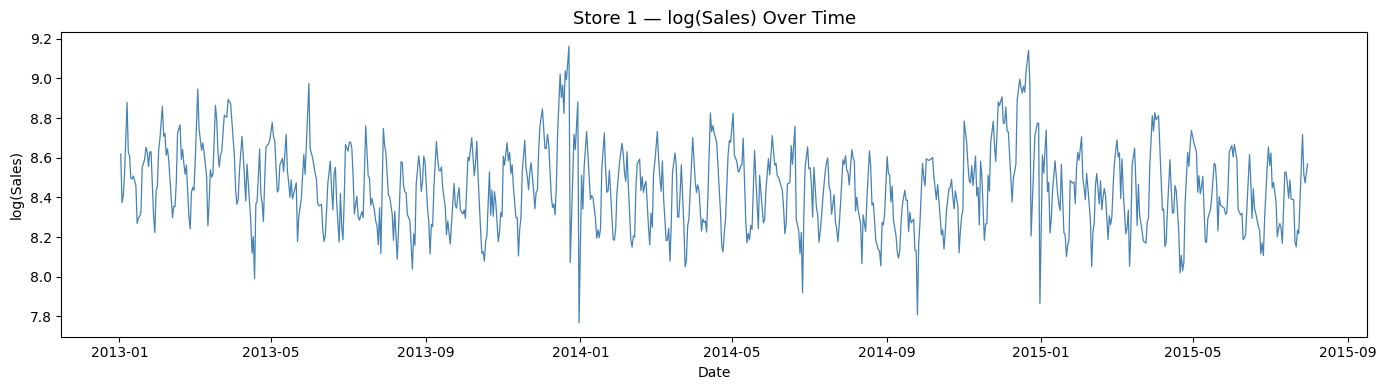

In [3]:
STORE_ID = 1

store_df = (
    df[df['Store'] == STORE_ID]
    .sort_values('Date')
    .set_index('Date')
)

# Use log-transformed target
series = store_df['Sales_log'].dropna()

plt.figure()
plt.plot(series.index, series.values, color='steelblue', linewidth=0.9)
plt.title(f'Store {STORE_ID} — log(Sales) Over Time')
plt.xlabel('Date')
plt.ylabel('log(Sales)')
plt.tight_layout()
plt.show()

## 4. Train / Validation Split

Train: 624 days  (2013-01-02 → 2015-01-22)
Val  : 157 days  (2015-01-23 → 2015-07-31)


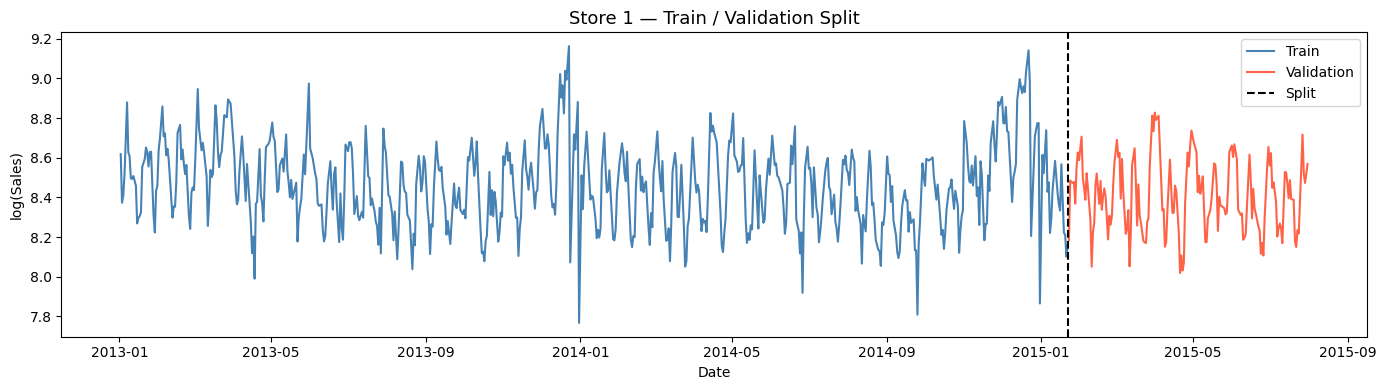

In [4]:
SPLIT_RATIO = 0.80
split_idx   = int(len(series) * SPLIT_RATIO)

train_series = series.iloc[:split_idx]
val_series   = series.iloc[split_idx:]

print(f'Train: {len(train_series)} days  ({train_series.index[0].date()} → {train_series.index[-1].date()})')
print(f'Val  : {len(val_series)} days  ({val_series.index[0].date()} → {val_series.index[-1].date()})')

plt.figure()
plt.plot(train_series, color='steelblue', label='Train')
plt.plot(val_series,   color='tomato',    label='Validation')
plt.axvline(train_series.index[-1], color='black', linestyle='--', label='Split')
plt.title(f'Store {STORE_ID} — Train / Validation Split')
plt.xlabel('Date')
plt.ylabel('log(Sales)')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Stationarity Check — ADF Test

ARIMA requires a stationary series.  
**ADF test:** H₀ = series has a unit root (non-stationary).  
If p-value < 0.05 → reject H₀ → series is stationary.

In [5]:
def adf_test(series, label='Series'):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'--- ADF Test: {label} ---')
    print(f'  ADF Statistic : {result[0]:.4f}')
    print(f'  p-value       : {result[1]:.4f}')
    print(f'  Critical (5%) : {result[4]["5%"]:.4f}')
    if result[1] < 0.05:
        print('  ✅ Stationary (reject H₀)')
    else:
        print('  ❌ Non-stationary (fail to reject H₀) → needs differencing')
    return result[1]

pval = adf_test(train_series, label='log(Sales)')

--- ADF Test: log(Sales) ---
  ADF Statistic : -4.4654
  p-value       : 0.0002
  Critical (5%) : -2.8663
  ✅ Stationary (reject H₀)


--- ADF Test: log(Sales) — 1st Difference ---
  ADF Statistic : -11.9644
  p-value       : 0.0000
  Critical (5%) : -2.8663
  ✅ Stationary (reject H₀)


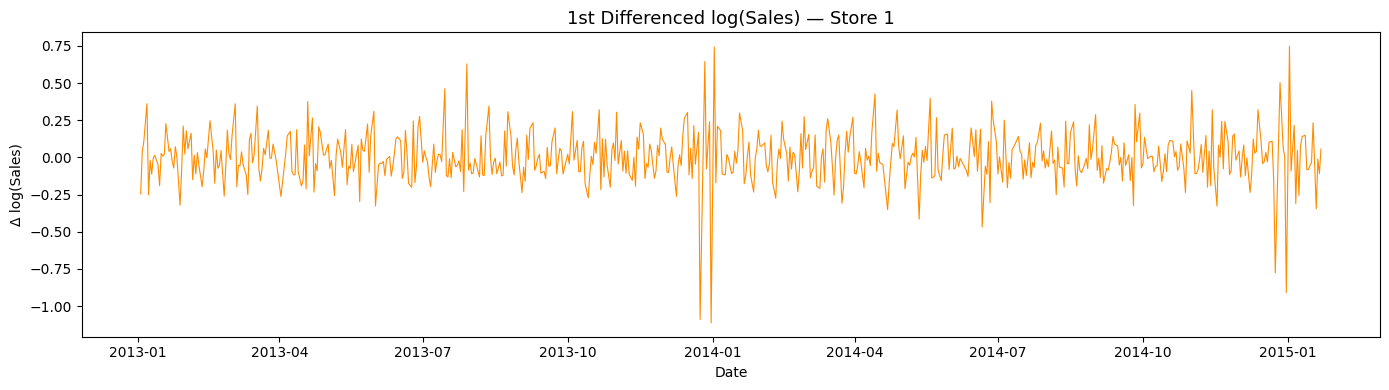

In [6]:
# If non-stationary → apply first difference and retest
train_diff = train_series.diff().dropna()
pval_diff  = adf_test(train_diff, label='log(Sales) — 1st Difference')

plt.figure()
plt.plot(train_diff, color='darkorange', linewidth=0.8)
plt.title('1st Differenced log(Sales) — Store 1')
plt.xlabel('Date')
plt.ylabel('Δ log(Sales)')
plt.tight_layout()
plt.show()

## 6. ACF & PACF Plots — Choose p, q

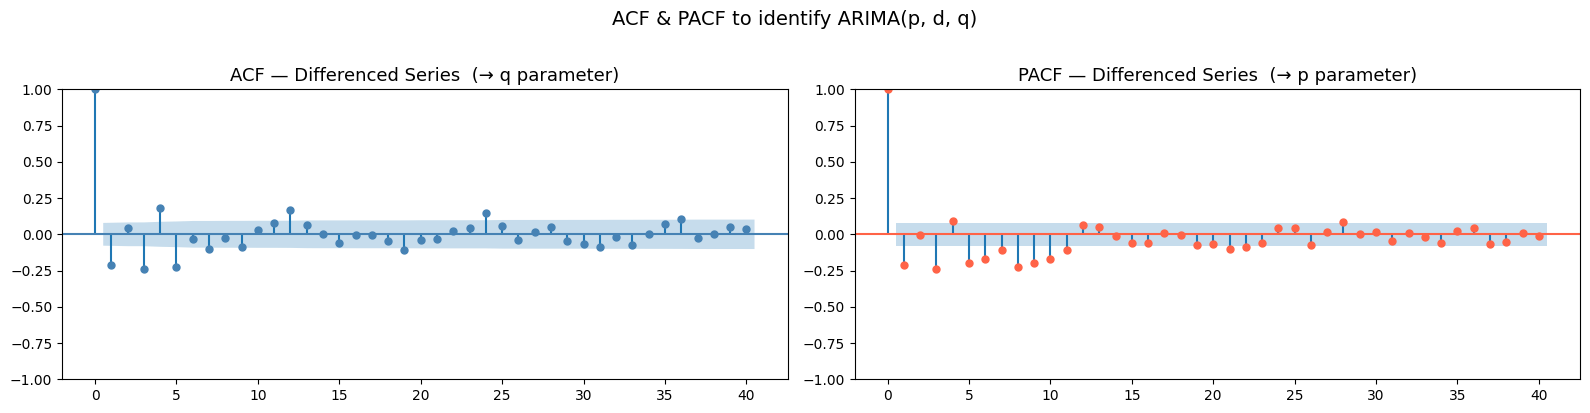


Reading the plots:
  PACF cuts off after lag k  →  p = k  (AR order)
  ACF  cuts off after lag k  →  q = k  (MA order)
  d = 1  (we used 1 differencing step)



In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(train_diff,  lags=40, ax=axes[0], color='steelblue')
axes[0].set_title('ACF — Differenced Series  (→ q parameter)')

plot_pacf(train_diff, lags=40, ax=axes[1], color='tomato', method='ols')
axes[1].set_title('PACF — Differenced Series  (→ p parameter)')

plt.suptitle('ACF & PACF to identify ARIMA(p, d, q)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/acf_pacf.png', dpi=150)
plt.show()

print("""
Reading the plots:
  PACF cuts off after lag k  →  p = k  (AR order)
  ACF  cuts off after lag k  →  q = k  (MA order)
  d = 1  (we used 1 differencing step)
""")

## 7. Fit ARIMA Manually

In [8]:
# Starting point from ACF/PACF — adjust after seeing auto_arima result
p, d, q = 2, 1, 2

print(f'Fitting ARIMA({p},{d},{q}) on Store {STORE_ID} training data...')

arima_manual = ARIMA(train_series, order=(p, d, q))
arima_manual_fit = arima_manual.fit()

print(arima_manual_fit.summary())

Fitting ARIMA(2,1,2) on Store 1 training data...
                               SARIMAX Results                                
Dep. Variable:              Sales_log   No. Observations:                  624
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 277.671
Date:                Sat, 21 Feb 2026   AIC                           -545.342
Time:                        20:11:39   BIC                           -523.169
Sample:                             0   HQIC                          -536.725
                                - 624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1861      0.070     -2.656      0.008      -0.323      -0.049
ar.L2          0.6315      0.042     15.029      0.000       0.549       0.714
ma.

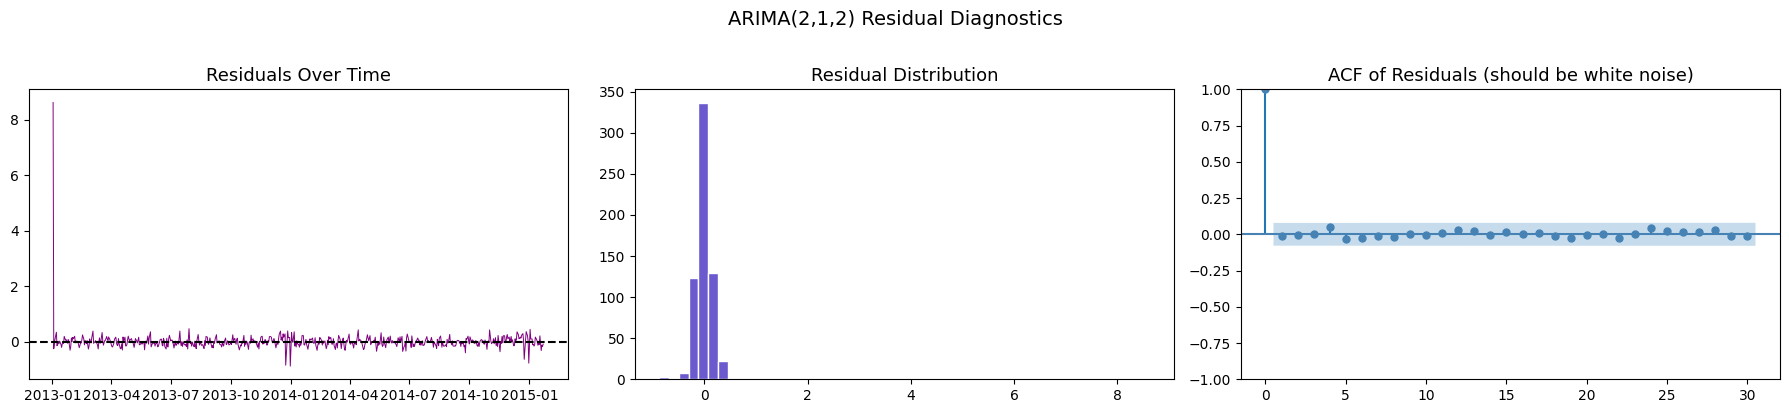

In [9]:
# Residual diagnostics
residuals = arima_manual_fit.resid

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(residuals, color='purple', linewidth=0.7)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('Residuals Over Time')

axes[1].hist(residuals, bins=50, color='slateblue', edgecolor='white')
axes[1].set_title('Residual Distribution')

plot_acf(residuals, lags=30, ax=axes[2], color='steelblue')
axes[2].set_title('ACF of Residuals (should be white noise)')

plt.suptitle(f'ARIMA({p},{d},{q}) Residual Diagnostics', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Auto ARIMA — Find Best Order Automatically

In [10]:
print('Running auto_arima (this may take a minute)...')

auto_model = auto_arima(
    train_series,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,              # auto-determine d via ADF test
    seasonal=False,      # we capture seasonality via features; keep ARIMA simple
    information_criterion='aic',
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True           # prints each model tested
)

print(f'\nBest order : ARIMA{auto_model.order}')
print(f'Best AIC   : {auto_model.aic():.2f}')

Running auto_arima (this may take a minute)...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4437.810, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3611.338, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-434.841, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-434.711, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2861.687, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-448.829, Time=0.53 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-448.880, Time=1.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-447.197, Time=0.41 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-479.264, Time=2.00 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-475.748, Time=0.45 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-466.692, Time=2.23 sec
 

In [11]:
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  624
Model:               SARIMAX(0, 0, 4)   Log Likelihood                 295.898
Date:                Sat, 21 Feb 2026   AIC                           -579.796
Time:                        20:16:16   BIC                           -553.179
Sample:                             0   HQIC                          -569.453
                                - 624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.4572      0.018    480.347      0.000       8.423       8.492
ma.L1          0.6819      0.031     21.937      0.000       0.621       0.743
ma.L2          0.5313      0.049     10.741      0.0

## 9. Forecast on Validation Set

In [12]:
n_forecast = len(val_series)

# --- Forecast from auto_arima ---
forecast_log, conf_int = auto_model.predict(n_periods=n_forecast, return_conf_int=True)

# Convert back from log space
forecast_sales    = np.expm1(forecast_log)
actual_sales      = np.expm1(val_series.values)
conf_lower_sales  = np.expm1(conf_int[:, 0])
conf_upper_sales  = np.expm1(conf_int[:, 1])

forecast_dates = val_series.index

print(f'Forecast horizon : {n_forecast} days')
print(f'Sample forecast  : {forecast_sales[:5].round(0)}')

Forecast horizon : 157 days
Sample forecast  : 624    3536.0
625    4096.0
626    4397.0
627    4510.0
628    4708.0
dtype: float64


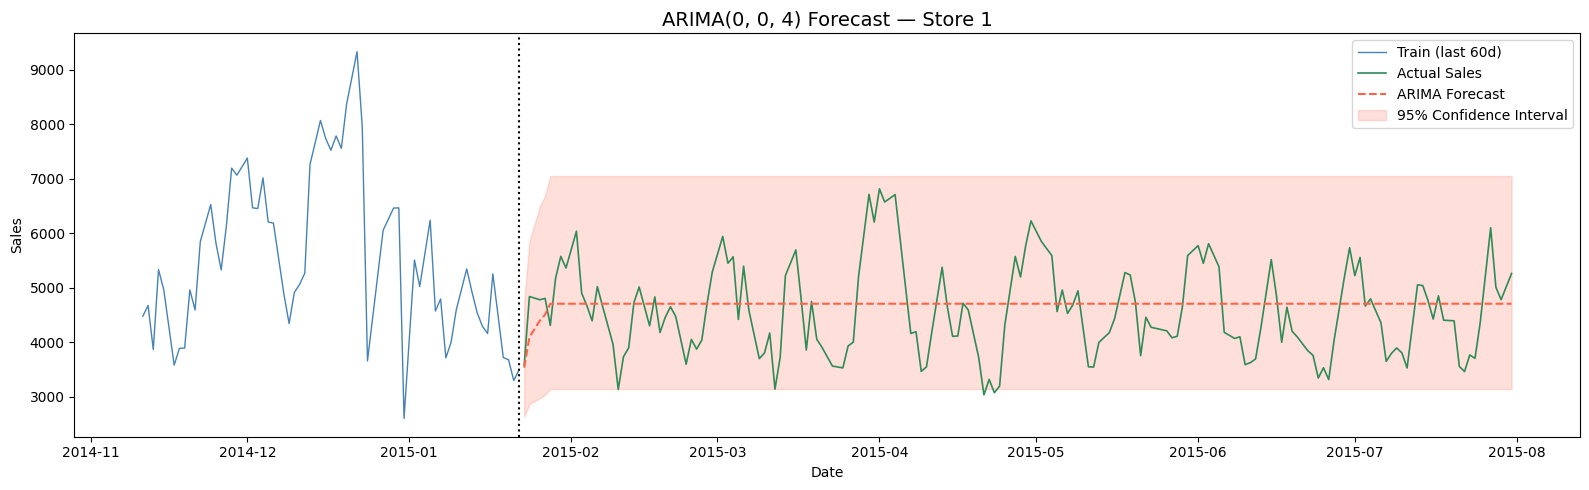

In [13]:
# Plot forecast vs actuals
fig, ax = plt.subplots(figsize=(16, 5))

# Show last 60 days of train for context
train_tail = np.expm1(train_series.iloc[-60:])
ax.plot(train_tail.index, train_tail.values,
        color='steelblue', linewidth=1, label='Train (last 60d)')

ax.plot(forecast_dates, actual_sales,
        color='seagreen', linewidth=1.2, label='Actual Sales')
ax.plot(forecast_dates, forecast_sales,
        color='tomato',  linewidth=1.5, linestyle='--', label='ARIMA Forecast')

ax.fill_between(forecast_dates, conf_lower_sales, conf_upper_sales,
                alpha=0.2, color='tomato', label='95% Confidence Interval')

ax.axvline(train_series.index[-1], color='black', linestyle=':', linewidth=1.5)
ax.set_title(f'ARIMA{auto_model.order} Forecast — Store {STORE_ID}', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/arima_forecast.png', dpi=150)
plt.show()

## 10. Evaluate — MAE & RMSE

In [14]:
def evaluate(actual, predicted, label='Model'):
    mae  = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100
    print(f'\n=== {label} ===')
    print(f'  MAE  : {mae:>10,.2f}')
    print(f'  RMSE : {rmse:>10,.2f}')
    print(f'  MAPE : {mape:>9.2f}%')
    return {'label': label, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

results = []

# --- Auto ARIMA ---
r1 = evaluate(actual_sales, forecast_sales, label=f'ARIMA{auto_model.order} (auto)')
results.append(r1)

# --- Manual ARIMA ---
manual_forecast_log = arima_manual_fit.forecast(steps=n_forecast)
manual_forecast     = np.expm1(manual_forecast_log)
r2 = evaluate(actual_sales, manual_forecast, label=f'ARIMA({p},{d},{q}) (manual)')
results.append(r2)

# --- Naive baseline: last known value ---
naive_forecast = np.full(n_forecast, np.expm1(train_series.iloc[-1]))
r3 = evaluate(actual_sales, naive_forecast, label='Naive Baseline (last value)')
results.append(r3)


=== ARIMA(0, 0, 4) (auto) ===
  MAE  :     694.45
  RMSE :     837.09
  MAPE :     16.22%

=== ARIMA(2,1,2) (manual) ===
  MAE  :     695.83
  RMSE :     838.37
  MAPE :     16.20%

=== Naive Baseline (last value) ===
  MAE  :   1,068.36
  RMSE :   1,322.34
  MAPE :     21.39%



=== Model Comparison ===
                                 MAE     RMSE   MAPE
label                                               
ARIMA(0, 0, 4) (auto)         694.45   837.09  16.22
ARIMA(2,1,2) (manual)         695.83   838.37  16.20
Naive Baseline (last value)  1068.36  1322.34  21.39


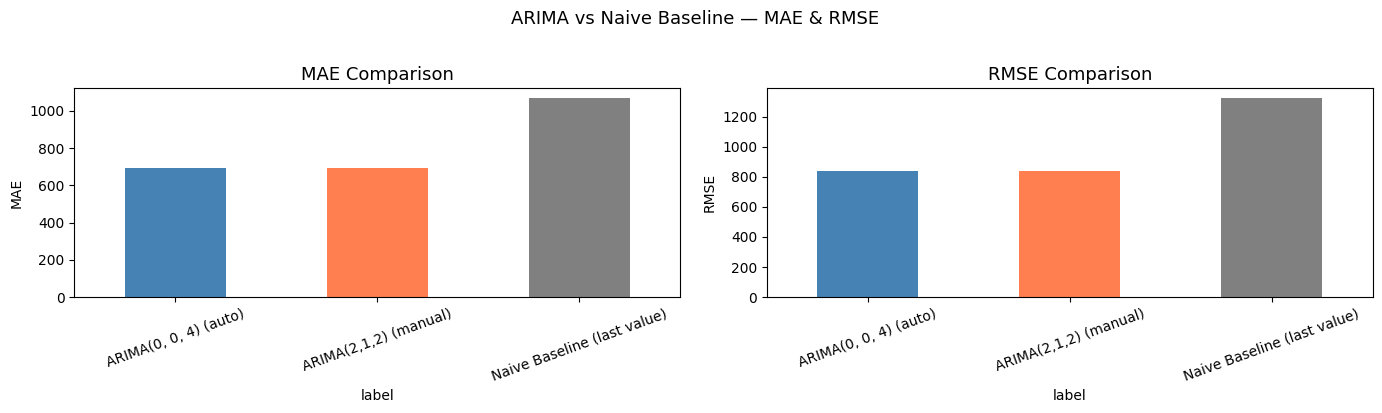

In [15]:
# Summary table
results_df = pd.DataFrame(results).set_index('label')
print('\n=== Model Comparison ===')
print(results_df.round(2))

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
results_df['MAE'].plot(kind='bar',  ax=axes[0], color=['steelblue','coral','gray'], rot=20)
axes[0].set_title('MAE Comparison')
axes[0].set_ylabel('MAE')

results_df['RMSE'].plot(kind='bar', ax=axes[1], color=['steelblue','coral','gray'], rot=20)
axes[1].set_title('RMSE Comparison')
axes[1].set_ylabel('RMSE')

plt.suptitle('ARIMA vs Naive Baseline — MAE & RMSE', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/arima_evaluation.png', dpi=150)
plt.show()

## 11. Save Model

In [16]:
# Save auto_arima model
with open('../models/arima_model.pkl', 'wb') as f:
    pickle.dump(auto_model, f)

print('Model saved to models/arima_model.pkl ✅')

# Save results
results_df.to_csv('../reports/arima_results.csv')
print('Results saved to reports/arima_results.csv ✅')

Model saved to models/arima_model.pkl ✅
Results saved to reports/arima_results.csv ✅


## 12. Summary

### Store analyzed      : 1                               
Auto ARIMA order    : ARIMA(0, 0, 4)                       
Manual ARIMA order  : ARIMA(2,1,2)                        
Best model (MAE)    : ARIMA(2, 1, 2) (manual)

## ARIMA Limitations                                      
• Univariate — ignores Promo, StoreType, holidays      
• Fitted per store — doesn't scale to 1115 stores      
• Assumes linear relationships 